100%|██████████| 170498071/170498071 [00:05<00:00, 29724763.62it/s]


Extracting ./control/cifar-10-python.tar.gz to ./control
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


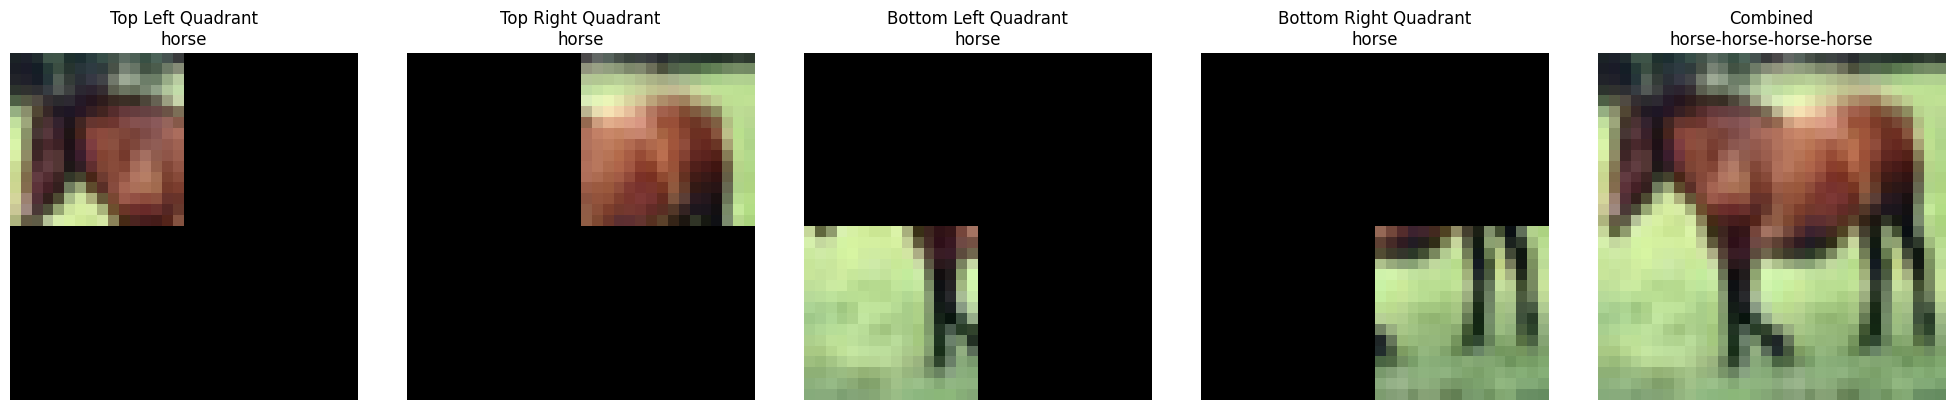

Files already downloaded and verified
Iteration 1
Training TL...
TL 0.3996
Training TR...
TR 0.3423
Training BL...
BL 0.3997
Training BR...
BR 0.412
avg 0.1631
Iteration 2
Training TL...
TL 0.4796
Training TR...
TR 0.4101
Training BL...
BL 0.4534
Training BR...
BR 0.5447
avg 0.3574
Iteration 3
Training TL...
TL 0.568
Training TR...
TR 0.4811
Training BL...
BL 0.5055
Training BR...
BR 0.5779
avg 0.5251
Iteration 4
Training TL...
TL 0.5978
Training TR...
TR 0.5146
Training BL...
BL 0.5455
Training BR...
BR 0.5852
avg 0.621
Iteration 5
Training TL...
TL 0.6253
Training TR...
TR 0.4866
Training BL...
BL 0.5717
Training BR...
BR 0.5847
avg 0.6643
Iteration 6
Training TL...
TL 0.6179
Training TR...
TR 0.5203
Training BL...
BL 0.5868
Training BR...
BR 0.5701
avg 0.6855
Iteration 7
Training TL...
TL 0.6276
Training TR...
TR 0.5338
Training BL...
BL 0.6062
Training BR...
BR 0.5736
avg 0.6982
Iteration 8
Training TL...
TL 0.6181
Training TR...
TR 0.5408
Training BL...
BL 0.6151
Training BR...
BR

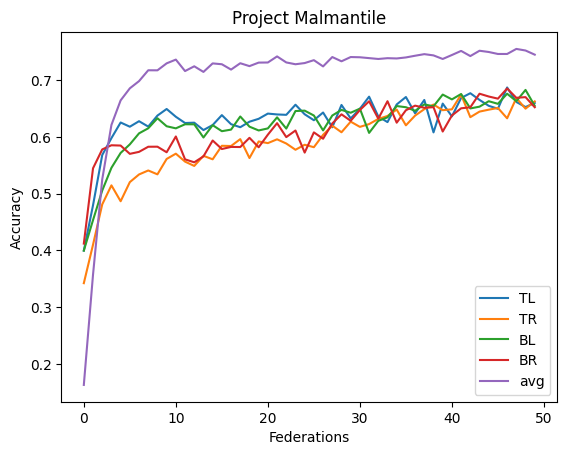

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import datetime
import copy

# Constants and global settings
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.0001
BATCH_SIZE = 10
ALL_HANDS_ON_DECK = 50


# Transformations
class QuadrantTransform:
    def __init__(self, quadrant):
        self.quadrant = quadrant

    def __call__(self, img):
        tensor = transforms.ToTensor()(img)
        blank = torch.zeros_like(tensor)
        slices = {
            "tl": (slice(None), slice(0, 16), slice(0, 16)),
            "tr": (slice(None), slice(0, 16), slice(16, 32)),
            "bl": (slice(None), slice(16, 32), slice(0, 16)),
            "br": (slice(None), slice(16, 32), slice(16, 32)),
        }
        blank[slices[self.quadrant]] = tensor[slices[self.quadrant]]
        return (blank - 0.5) / 0.5


def create_transform(quadrant):
    return transforms.Compose([QuadrantTransform(quadrant)])


def load_dataset(transform, train=True):
    return torchvision.datasets.CIFAR10(
        root="./data", train=train, download=True, transform=transform
    )


def create_loader(dataset, batch_size=BATCH_SIZE):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)


def overlay_images(img_tl, img_tr, img_bl, img_br):
    # Assuming each image has the same dimensions
    height, width, channels = img_tl.shape

    # Create an empty canvas of the same dimensions
    combined_img = np.zeros((height, width, channels))

    # Place the non-zero pixels from each image onto the canvas
    # For this to work, the regions where the images overlap should have zeroed out pixels in all but one of the images
    combined_img += img_tl
    combined_img += img_tr
    combined_img += img_bl
    combined_img += img_br

    return combined_img


def show_example_image(tl_loader, tr_loader, bl_loader, br_loader):
    classes = (
        "plane",
        "car",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    )

    # Get a batch from each loader
    tl_images, tl_labels = next(iter(tl_loader))
    tr_images, tr_labels = next(iter(tr_loader))
    bl_images, bl_labels = next(iter(bl_loader))
    br_images, br_labels = next(iter(br_loader))

    # Select a random index from the batch
    idx = np.random.randint(0, len(tl_images))

    # Denormalize the images for display
    def denormalize(img):
        return img * 0.5 + 0.5

    # Select the image from the batch using the random index and denormalize
    img_tl = denormalize(tl_images[idx]).numpy().transpose(1, 2, 0)
    img_tr = denormalize(tr_images[idx]).numpy().transpose(1, 2, 0)
    img_bl = denormalize(bl_images[idx]).numpy().transpose(1, 2, 0)
    img_br = denormalize(br_images[idx]).numpy().transpose(1, 2, 0)

    combined_img = overlay_images(img_tl, img_tr, img_bl, img_br)

    # Extract labels for the selected images (just as a demonstration, we can show multiple labels if needed)
    label_combined = f"{classes[tl_labels[idx].item()]}-{classes[tr_labels[idx].item()]}-{classes[bl_labels[idx].item()]}-{classes[br_labels[idx].item()]}"

    # Plotting
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))

    axs[0].imshow(img_tl)
    axs[0].set_title(f"Top Left Quadrant\n{classes[tl_labels[idx].item()]}")
    axs[0].axis("off")

    axs[1].imshow(img_tr)
    axs[1].set_title(f"Top Right Quadrant\n{classes[tr_labels[idx].item()]}")
    axs[1].axis("off")

    axs[2].imshow(img_bl)
    axs[2].set_title(f"Bottom Left Quadrant\n{classes[bl_labels[idx].item()]}")
    axs[2].axis("off")

    axs[3].imshow(img_br)
    axs[3].set_title(f"Bottom Right Quadrant\n{classes[br_labels[idx].item()]}")
    axs[3].axis("off")

    axs[4].imshow(combined_img)
    axs[4].set_title(f"Combined\n{label_combined}")
    axs[4].axis("off")

    plt.tight_layout()
    plt.show()


def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
    )


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64  # Increase from 16 to 64 for CIFAR-10
        self.conv = conv3x3(3, 64)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], 2)
        self.layer3 = self.make_layer(block, 256, layers[2], 2)
        self.layer4 = self.make_layer(block, 512, layers[3], 2)  # Added another layer
        self.avg_pool = nn.AvgPool2d(4)  # Adjust from 8 to 4 for CIFAR-10's 32x32
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)  # Pass through the additional layer
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


# Training and testing functions
def test_model(debug_string, model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(debug_string, accuracy)
    return accuracy


def train_model(model, trainloader, optimizer):
    model.train().to(DEVICE)
    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def average_weights(*models):
    avg_dict = {
        key: sum([model.state_dict()[key] for model in models]) / len(models)
        for key in models[0].state_dict().keys()
    }
    return avg_dict


def federated_learning(original_model):
    loaders = [trainloader_tl, trainloader_tr, trainloader_bl, trainloader_br]
    histories = [tl_history, tr_history, bl_history, br_history]
    labels = ["TL", "TR", "BL", "BR"]

    models = [copy.deepcopy(original_model).to(DEVICE) for _ in loaders]
    optimizers = [optim.Adam(model.parameters(), lr=LEARNING_RATE) for model in models]

    for model, loader, history, label in zip(models, loaders, histories, labels):
        print(f"Training {label}...")
        train_model(model, loader, optimizers[models.index(model)])
        history.append(test_model(label, model, test_loader))

    avg_state_dict = average_weights(*models)
    new_model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(DEVICE)
    new_model.load_state_dict(avg_state_dict)
    avg_history.append(test_model("avg", new_model, test_loader))
    return new_model


# Main Execution
if __name__ == "__main__":
    # Data Preparation
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )

    trainsets = [
        load_dataset(create_transform(quadrant))
        for quadrant in ["tl", "tr", "bl", "br"]
    ]
    trainloader_tl, trainloader_tr, trainloader_bl, trainloader_br = [
        create_loader(trainset) for trainset in trainsets
    ]

    show_example_image(trainloader_tl, trainloader_tr, trainloader_bl, trainloader_br)

    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform
    )
    test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

    # Initialize Model and Criterion
    model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(DEVICE)
    criterion = nn.CrossEntropyLoss()

    # Training and Testing
    tl_history, tr_history, bl_history, br_history, avg_history = [], [], [], [], []

    for i in range(ALL_HANDS_ON_DECK):
        print(f"Iteration {i+1}")
        model = federated_learning(model)

    # Plot Results
    for history, label in zip(
        [tl_history, tr_history, bl_history, br_history, avg_history],
        ["TL", "TR", "BL", "BR", "avg"],
    ):
        plt.plot(history, label=label)

    plt.legend()
    plt.xlabel("Federations")
    plt.ylabel("Accuracy")
    plt.title("Project Malmantile")

    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    plt.savefig("malmantile-" + current_time + ".png")
    plt.show()

    # Save Model
    torch.save(model.state_dict(), "malmantile.ckpt")
